## Shape: challenge for DS position
--- 

Applicant name: **Mauricio Branbilla Junior**

--- 

### Challenge description

To enable the operations of an FPSO, we use sensors to make sure the equipment does not fail. These sensors measure different parameters of the equipment in different setup configurations (preset 1 and preset 2) over time. We want you to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing. To solve this problem, we expect you to answer a few questions regarding the attached dataset:

    1 – Calculate how many times the equipment has failed.

    2 – Categorize equipment failures by setups configurations (preset 1 and preset 2).

    3 – Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).

    4 – Create a model using the technique you think is most appropriate and measure its performance.

    5 – Analyze variable importance.



**Few Tips:**

Please write down any insights and conclusions throughout your code when you think it is necessary, keeping them as clear and complete as possible. Think of this exercise as your first technical report for Shape!
At Shape, we generally work with Python, and you are encouraged to use this language. However, if you can't use Python, you can use R or Julia for this assessment. We value clean, concise, and production-ready code.
Once you’re done, please send us your analyses and answers in an Html notebook, but also other conclusions and insights that you think are relevant to the project. We value creativity!
Feel free to discuss how you think you would put the models in production.


**What do we expect you to do:**

Present storytelling of data and analyses performed.
Problem comprehension.
Data exploration.
Logic and concise model definition.
Rationale explanation.
Results evaluation.


**What you DON'T need to do?**

Super complex models with no logic or rationale behind them.

---

### Some notes about my solution:

**What will be my approach?**

Keeping in mind the bias-variance tradeoff and the fact of the dataset has just a few predictors, I'll look for the simplest model (i.e. with the less complexity as possible) that can leads to satisfatory predictions. Given that, I'll test two models:

- (A) Logistic Regression: a linear classification model
- (B) Randon Forest: a non-linear (tree-based) classification model

The choose between these models will be done by comparing the performance metric. If the performance metrics are similar, we'll choose that have lower complexity (in this case, the Logistic Regression Model) - in other words, we just choose a more complex model if we have a realistic gain in that approach. Both of these models will give a inference of the probability of failure.

<!-- In addition to, we'll compare the results with annother approach using a survival model: 

- (C) Random Survival Forest: a non-linear (tree-based) survival model

The survival model requires two targets: one representing the _time to event_ and another representing the occurence of the event. In the provided dataset, we can calculate the time to event by counting the quantity of cicles between failures. This kind of model will give, as well as the probability of failure, a inference of how much time until the failure, and this information can be very useful for the context of planning preventive maitenances.  -->



**What are the performance metrics that I'll use?**

One fact about the provided dataset is that the data is **unbalanced** (about 8.25% of the data was labeled as failure). 

Looking for the costs envolved in machinary maintence and thinking about the impact of false negatives or false positives classifications at this cost:

- False positives means that the preventive maintenance may be done without needed
- False negatives means that the preventive maintenance will not be done and the equipment may presents a failure, reprensenting a corrective maintence cost - this cost tends to be significant higher than the preventive maintenance and we want to avoid that.

Given that poits, we want to be focused in reduce the false negative rate (i.e. the sensibility). Given that, the PR AUC Score (Area Under Precision-Recall Curve) might be more adequated than ROC AUC Score for this case. 

<!-- For the Survival Model, we'll also use the _Concordance Index_ (c-index) to measure the fit quality. -->

--- 
### <a id='index'>Table of Contents:</a>

- [1. Environment setup](#sec_1)
- [2. Data overview](#sec_2)
- [3. The Failure Prediction Model](#sec_3)
- [4. Final Considerations](#sec_4)


### <a id='sec_1'>1. Environment setup</a>

At this section:

- Set some variables with paths from current working directory
- Install and import required Python libraries
- Set some constants that will be used on the solutions 


[(back to Table of Contents)](#index)


In [1]:
# Set working directory and paths

import os

MAIN_PATH = os.getcwd()
DATA_FILE_PATH = MAIN_PATH + '/data/O_G_Equipment_Data.xlsx'

print(f"Current Path: {MAIN_PATH}")


Current Path: /Users/mbranbilla/Projects/shape_challenge


In [2]:
%%capture
# Requirements

import subprocess
import sys

requirements = """#Python 3.11.4
pandas==2.0
numpy>=1.21.0, <1.27.0, !=1.24.0
scipy==1.10
scikit-learn==1.3
matplotlib==3.7
seaborn==0.12.2
shap==0.42.1
tqdm
"""
with open('requirements.txt', 'w') as f:
    f.write(requirements)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])

del(requirements)
del(subprocess)
del(sys)
del(f)

In [3]:
# Import mudules
from abc import ABC, abstractmethod

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from matplotlib.gridspec import GridSpec

from scipy.stats import ttest_ind, ttest_1samp, ks_2samp, t, sem
from sklearn.preprocessing import StandardScaler, TargetEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from shap import TreeExplainer, summary_plot

from tqdm import tqdm
from typing import Union

# Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


**Constants: a brief description of each seted value above:**

The constants will be identified with `UPPER_CASE` named variables.

- `RND_SEED` (int): value to be used as seed for random number generation, necessary for reproducibility in many methods used in the solution (this value is passed on every method that have an optional argument called `random_state`)




In [4]:
# Constants
RND_SEED = 42

### <a id='sec_2'>2. Data overview</a>

At this section:

- Read dataset from provided XLSX file
- Show basic statistics and informations about the data
- Show the solution of following challenge objectives:

    - Calculate how many times the equipment has failed
    - Categorize equipment failures by setups configurations (preset 1 and preset 2)
    -  Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)

[(back to Table of Contents)](#index)

In [5]:
# Load data
df = pd.read_excel(DATA_FILE_PATH)

# Set of Column names by context 
NUM_FEATURE_COLS = ['Temperature', 'Pressure', 'VibrationX', 
                    'VibrationY', 'VibrationZ', 'Frequency']
PERIOD_COLS = ['Cycle']
PRESET_COLS = ['Preset_1', 'Preset_2']
TARGET_COL = 'Fail'
FULL_FEATURE_COLS = PRESET_COLS + NUM_FEATURE_COLS


df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


**Adjustments**

- Change the target variable `Fail` from boolean to integer (by replacing False:=0; True:=1)
- Check dtypes

In [6]:
# Change Target Variable from boolean to integer
df[TARGET_COL] = df[TARGET_COL].astype(int)

# Checking new dtypes
print(df.dtypes)

# Print the mean of target
print("\nMean of y: {:.4f}".format(df[TARGET_COL].mean()))

Cycle            int64
Preset_1         int64
Preset_2         int64
Temperature    float64
Pressure       float64
VibrationX     float64
VibrationY     float64
VibrationZ     float64
Frequency      float64
Fail             int64
dtype: object

Mean of y: 0.0825


**Basic statistics about the dataset**

In [7]:
# Basic Statistics of numerical features
df[NUM_FEATURE_COLS].describe()

,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


**Missing values and Outliers**

First we'll check the presence or absence of missing values.

In [8]:
# Get the proportion of missing values for each column (including the target `Fail`)
df.isna().sum() / df.shape[0]

Cycle          0.0
Preset_1       0.0
Preset_2       0.0
Temperature    0.0
Pressure       0.0
VibrationX     0.0
VibrationY     0.0
VibrationZ     0.0
Frequency      0.0
Fail           0.0
dtype: float64

For obtain more knowledge about the data, I'll use boxplot to visualize how each variable is distributed and check the presence of outliers.

**Why it's important?**

When we test a linear model, such as Logistic Regression, Outliers values might distorce the feature space resulting in inaccurate model fitting. 


Text(0.5, 1.0, 'Boxplot of numerical features')

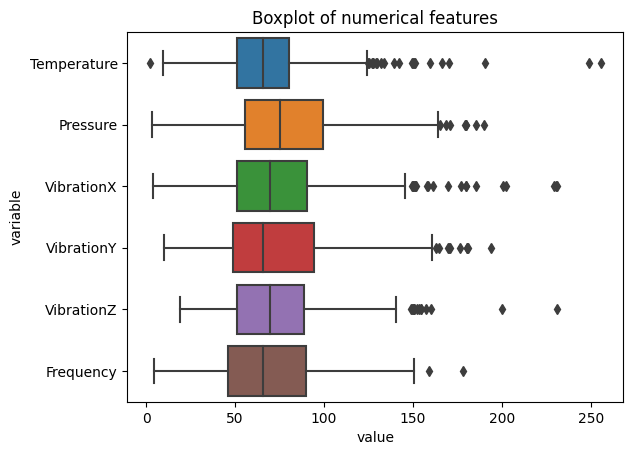

In [9]:
# Box plot

sns.boxplot(data=pd.melt(df[NUM_FEATURE_COLS]), 
              x="value",
              y="variable",
              orient='h')

plt.title('Boxplot of numerical features')

**Conclusions:**

- Dataset hasn't missing values
- All numeric variables are in a similar scale
- All numeric variables have superiors outliers
- Variable `Temperature` have inferior outliers



#### 2.1. Calculate how many times the equipment has failed

In [10]:
df['Fail'].value_counts()

Fail
0    734
1     66
Name: count, dtype: int64

In [11]:
df['Fail'].value_counts(normalize=True)

Fail
0    0.9175
1    0.0825
Name: proportion, dtype: float64

**Conclusion:** 

The equipment has failed by 66 times of 800 cycles. This represent a failure rate of 8.25%.

**2.2 Categorize equipment failures by setups configurations (preset 1 and preset 2)**

This point will be treated at two steps:

- Fisrt, we'll check the failure rate by setup configurations individually
- After, we'll check the effect of combining the two setups


In [12]:
# Function: 
#           plot the failure rate by preset on horizontal 
#           bar plot with percentage format/

def plot_failure_by_preset(df:pd.DataFrame,
                           ax:plt.axes, 
                           preset_col:str,
                           target_col:str = TARGET_COL, 
                           return_result_df:bool = True):

    ps_df = df[[preset_col, target_col]] \
                .groupby(preset_col) \
                .agg({target_col: 'mean'}) \
                .reset_index() \
                .sort_values(by=target_col)

    ps_df['Failure_Rate'] = ps_df[target_col] \
                            .apply(lambda x: x*100)

    labels = ps_df['Failure_Rate'].round(2).astype('str') + '%'
    ps_df.plot.barh(x=preset_col, y='Failure_Rate', legend=False, ax=ax);

    max_x = int(ps_df['Failure_Rate'].max()) + 2

    for container in ax.containers:
        ax.bar_label(container, labels=labels)
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())  
        
    ax.set_xlim((0, max_x))
    
    ax.set_title(f'Failure Rate for {preset_col}');

    if return_result_df:
        ps_df['Failure_Rate'] = ps_df[target_col]
        return ax, ps_df.drop(target_col, axis=1)
    else:
        return ax


For individually setups `Preset1` and `Preset2`

Text(0.5, 0.98, 'Individualy failure rates by Preset 1 and Preset 2')

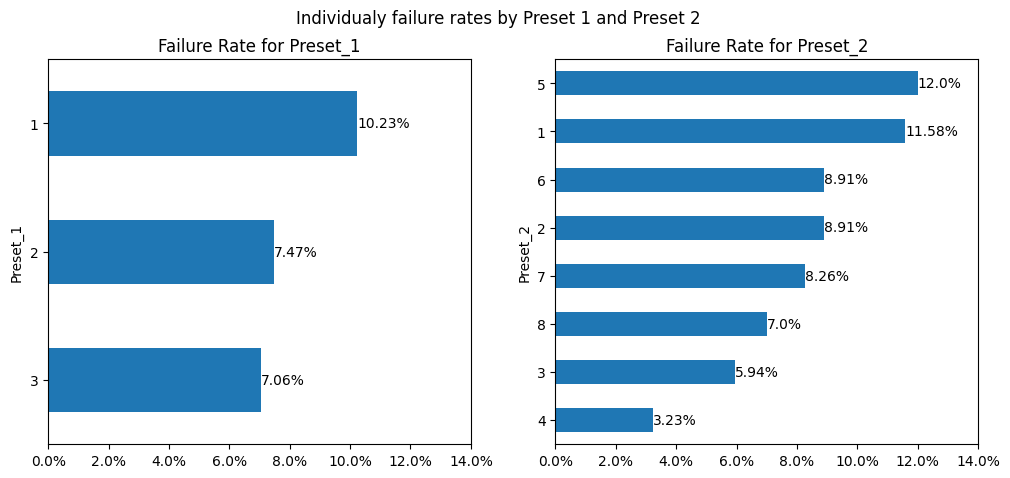

In [13]:
# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False, sharex=True)

# Preset 1
ax1, ps1_df = plot_failure_by_preset(df, ax1, PRESET_COLS[0], TARGET_COL)

# Preset 2
ax2, ps2_df = plot_failure_by_preset(df, ax2, PRESET_COLS[1], TARGET_COL)


# Combining the plots
fig.suptitle('Individualy failure rates by Preset 1 and Preset 2')

Combining the presets: now we have a comparision of 24 possibles combinations envonvilng `Preset1` (3 possibilities) and `Preset2` (8 possibilities).

For label these combinations, we'll create a new column named as `Combined_Presets` with the code generated by  `<Preset1 value>_<Preset2 value>` - for example, if `Preset1` has the value 2 and `Preset1` has the value 7, the variable `Combined_Presets` will have the label `2_7`.

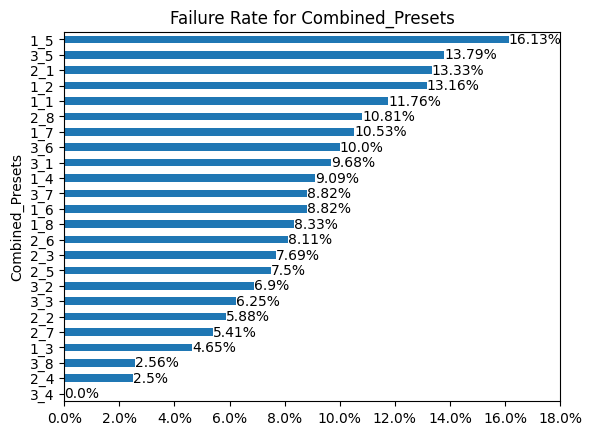

In [14]:
# Creating a auxiliary dataframe
aux_df = df.copy()

# Add a column with the combinations of configuration setups
aux_df['Combined_Presets'] = [str(ps1) + '_' + str(ps2) \
                              for ps1, ps2 in zip(aux_df[PRESET_COLS[0]],
                                                  aux_df[PRESET_COLS[1]])]

# Using the same function to plot
ax3 = plt.axes()
ax3, ps_df = plot_failure_by_preset(aux_df, ax3, 'Combined_Presets', TARGET_COL)

For a proper analysis, I'll use quantiles to classifier the failure rates inside tree categories:

- Failure rate below Q1 (0.25): label `low`
- Failure rate between Q1 (0.25) and Q3 (0.75): label `moderated`
- Failure rate over Q3 (0.75): label `high`

I'll keep that information at variable `setup_failure_rate` on DataFrame `ps_df` (returned by plot function).

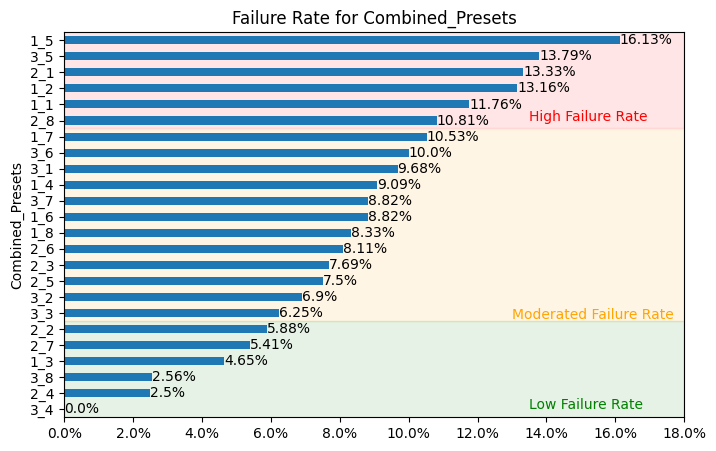

In [15]:
# Get bins (used in plot)
_, bins = pd.qcut(ps_df['Failure_Rate'], [0, .25, .75, 1.], retbins=True)

# Create new axes
fig, ax4 = plt.subplots(1, 1, figsize=(8, 5), sharey=True, sharex=True)
# ax4 = plt.axes()

# Add regions to plot
ax4.axhspan(-1, 5.5, color='green', alpha=0.1)
ax4.axhspan(5.51, 17.5, color='orange', alpha=0.1)
ax4.axhspan(17.51, 30, color='red', alpha=0.1)

ax4.annotate("Low Failure Rate", (13.5, 0), color='green')
ax4.annotate("Moderated Failure Rate", (13, 5.6), color='orange')
ax4.annotate("High Failure Rate", (13.5, 18), color='red')

# Show Plot 
ax4, ps_df = plot_failure_by_preset(aux_df, ax4, 'Combined_Presets', TARGET_COL)

# Add labels to DataFrame
ps_df['setup_failure_rate'] = pd.qcut(ps_df['Failure_Rate'],
                                      [0, .25, .75, 1.], 
                                      labels=['low', 'moderated', 'high'])


**Conclusions:**

- Failure rate tends to be higher when `Preset1` assumes value 3;
- Failure rate tends to be higher when `Preset2` assumes values 5 or 1;
- Looking at the `Preset1` and `Preset2` combinations, we can conclude:
    * Combinations with high failure rates:            
            <table>
            <tbody>
            <tr>
            <td>&nbsp;Preset1</td>
            <td>Preset2</td>
            <td>Failure Rate</td>
            </tr>
            <tr>
            <td>1</td>
            <td>5</td>
            <td>16.13%</td>
            </tr>
            <tr>
            <td>3</td>
            <td>5</td>
            <td>13.79%</td>
            </tr>
            <tr>
            <td>2</td>
            <td>1</td>
            <td>13.33%</td>
            </tr>
            <tr>
            <td>1</td>
            <td>2</td>
            <td>13.16%</td>
            </tr>
            <tr>
            <td>1</td>
            <td>1</td>
            <td>11.76%</td>
            </tr>
            <tr>
            <td>2</td>
            <td>8</td>
            <td>10.81%</td>
            </tr>
            </tbody>
            </table>
            <!-- DivTable.com -->

    * Combinations with lower failure rates:
        <table>
        <tbody>
        <tr style="height: 23px;">
        <td style="height: 23px;">&nbsp;Preset1</td>
        <td style="height: 23px;">Preset2</td>
        <td style="height: 23px;">Failure Rate</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">5.88%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">7</td>
        <td style="height: 23px;">5.41%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">1</td>
        <td style="height: 23px;">3</td>
        <td style="height: 23px;">4.65%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">3</td>
        <td style="height: 23px;">8</td>
        <td style="height: 23px;">2.56%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">4</td>
        <td style="height: 23px;">2.5%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">3</td>
        <td style="height: 23px;">4</td>
        <td style="height: 23px;">0.00%</td>
        </tr>
        </tbody>
        </table>
        <!-- DivTable.com -->


**2.3 Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)**

Fist I'll check if have differences in data distribution for each given parameter for cases of failures and non-failures. Here we can use box plot one more time to visualize that distributions and, after, run a statistical test to afirm that have relevant differences. 


After, we'll assign labels for each failure case with the main causes of failures.

Text(0.5, 1.0, 'Parameters Distributions: failures and not failures')

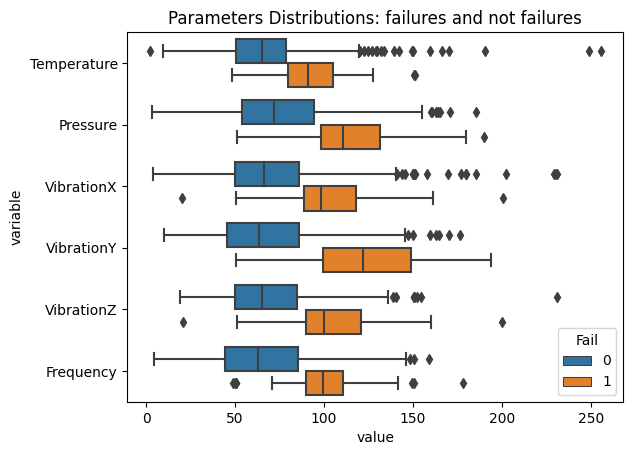

In [16]:
sns.boxplot(data=df.melt(id_vars=TARGET_COL, value_vars=NUM_FEATURE_COLS), 
            y='variable',
            x='value',
            hue=TARGET_COL,
            orient='h')

plt.title('Parameters Distributions: failures and not failures')

Looking for the plot above, we can cleary see that all parameters presents higher values for failure cases. 

On the table bellow, we can see some differences about distribution categorization for these parameters in cases of non-failures and failures. 

In [17]:
def q1(x): return x.quantile(0.25)

def q3(x): return x.quantile(0.75)

aggregations = {c: ['count', 'mean', 'std', 'median', 'min', q1, 'median', q3, 'max'] \
                for c in NUM_FEATURE_COLS}

aux_df = df.groupby(TARGET_COL).agg(aggregations).T
aux_df.columns = ['Non-Failure', 'Failure']

aux_df

Non-Failure     Failure
Temperature count    734.000000   66.000000
            mean      67.176884   92.469125
            std       24.824880   21.683670
            median    64.814877   90.928964
            min        2.089354   48.091962
            q1        50.471831   79.784598
            median    64.814877   90.928964
            q3        78.362952  104.960599
            max      255.607829  150.880308
Pressure    count    734.000000   66.000000
            mean      75.632790  116.422540
            std       30.561615   30.040055
            median    71.911241  110.619156
            min        3.480279   50.822002
            q1        53.709124   98.283167
            median    71.911241  110.619156
            q3        94.557459  131.353569
            max      185.406401  189.995681
VibrationX  count    734.000000   66.000000
            mean      71.494803  100.167190
            std       30.415831   28.109402
            median    66.358594   98.043755
            min        3.846343   20.120467
            q1        49.827841   88.622311
            median    66.358594   98.043755
            q3        86.093965  118.200618
            max      230.861142  200.749598
VibrationY  count    734.000000   66.000000
            mean      68.318455  122.481159
            std       29.010220   30.861777
            median    63.516837  122.115118
            min       10.057744   50.481820
            q1        45.626713   99.473948
            median    63.516837  122.115118
            q3        85.849744  148.611903
            max      176.197917  193.569947
VibrationZ  count    734.000000   66.000000
            mean      68.796672  106.003200
            std       25.678027   28.377486
            median    65.005965   99.669357
            min       18.784169   20.522642
            q1        50.108618   89.873117
            median    65.005965   99.669357
            q3        84.551724  120.635254
            max      230.951134  200.242674
Frequency   count    734.000000   66.000000
            mean      65.382995   99.812745
            std       27.943436   22.960578
            median    62.687313   99.212676
            min        4.380101   48.923777
            q1        44.516991   89.974024
            median    62.687313   99.212676
            q3        85.218644  110.702196
            max      158.811673  178.090303

In order to have a proprely comparision about these diferences on parameter's data distributions, a statistical test is required. For that data, we use the **t-test** with the null hypotesis that the two distributions (failure and non-failure) are statisticaly equal in a confidence interval - We can reject the null hypotesis if the p-value provided by the test are fewer than 0.05.

For the T-Test, the normality of distributions is just required for small samples (in general, for samples with less tham 30 observations). The sample from non-failure cases has 784 observations, because of that we don't need to check the normality to perform this test. 

Firstly we'll check if the two distributions (failures and non-failures) present statistically significant differences using the T-test for the mean of two distributions.

In [18]:
for c in NUM_FEATURE_COLS:

    dist_0 = df.loc[df[TARGET_COL]==0, c].values
    dist_1 = df.loc[df[TARGET_COL]==1, c].values

    t_stat, p_val =  ttest_ind(dist_1, dist_0)

    spaces_1 = " " * (15 - len(c))
    spaces_2 = " " * (4 - len(str(int(t_stat))))

    print(c + spaces_1 + '|    t-statistic: {:.2f}'.format(t_stat) + \
          spaces_2 + '| p-value: {:.4f}'.format(p_val))

Temperature    |    t-statistic: 8.01   | p-value: 0.0000
Pressure       |    t-statistic: 10.40  | p-value: 0.0000
VibrationX     |    t-statistic: 7.38   | p-value: 0.0000
VibrationY     |    t-statistic: 14.45  | p-value: 0.0000
VibrationZ     |    t-statistic: 11.18  | p-value: 0.0000
Frequency      |    t-statistic: 9.72   | p-value: 0.0000


**Conclusion:** has significative difference between cases os failure and non-failure for all parameters values.

In order to assign a reazon for each failure, we will check if the value of parameters is significantly different from the mean of non-failure sample. This can be done by a t-test with the null hypotesis "The value of the parameter of a failure example are statistically indistinguishable from the mean of non-failures" - For a confidence level of 95%, we can reject the null hypothesis if the p-value is fewer than 0.05.






In [19]:
# Function to calculate magnitude of components
def magnitude(x, y, z): return np.sqrt(x**2 + y**2 + z**2)

# Function to compare the value with the sample using t-test
def check_failure_reason(non_failure_param_dist:pd.Series,
                        failure_param_value:float,
                        param_name: str,
                        confidence_level:float = .95):
    
    sample_mean = np.mean(non_failure_param_dist)
    
    t_stat, p_val = ttest_1samp(non_failure_param_dist,
                                failure_param_value)

    if p_val < 1 - confidence_level:
        return param_name, abs(t_stat)
    else:
        return None, abs(t_stat)

cols = NUM_FEATURE_COLS

df_failures = df.loc[df[TARGET_COL]==1, cols]
df_nonfailures = df.loc[df[TARGET_COL]==0, cols]

# Putting all parameters on the same scale
# this is important to find the main cause of failure 
# by comparing the three values on the same scale
for c in cols:    
    scaler = StandardScaler().fit(df_nonfailures[c].values.reshape(-1, 1))
    
    df_nonfailures[c] = scaler.transform(df_nonfailures[c].values.reshape(-1, 1))
    df_failures[c] = scaler.transform(df_failures[c].values.reshape(-1, 1))


# Find the reason for each case
failure_reasons = []
all_failure_reasons = []

for row in df_failures.itertuples(index=False):

    tstats = []
    failure_cause = []

    for i, value in enumerate(row): 
        fc, ts= check_failure_reason(df_nonfailures[cols[i]],
                                     value,
                                     cols[i]
                                     )
        tstats.append(ts)
        failure_cause.append(fc)

    
    # Find the major cause of failure and append the parameter name as reason
    failure_reasons.append(cols[tstats.index(max(tstats))])
    all_failure_reasons.append(" | ".join([f for f in failure_cause if f is not None]))

df_failures['MainFailureReason'] = failure_reasons
df_failures['AllFailureReasons'] = all_failure_reasons

df_failures


,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,MainFailureReason,AllFailureReasons
12,0.509096,0.900335,1.620600,2.282905,1.834589,0.400362,VibrationY,Temperature | Pressure | VibrationX | Vibratio...
156,0.988330,0.318034,0.934225,0.931685,2.189106,0.680207,VibrationZ,Temperature | Pressure | VibrationX | Vibratio...
157,0.876300,0.412533,0.448946,1.910748,0.781597,1.247874,VibrationY,Temperature | Pressure | VibrationX | Vibratio...
158,0.870361,0.772603,0.579525,1.952911,0.604422,0.817750,VibrationY,Temperature | Pressure | VibrationX | Vibratio...
162,1.563714,1.148033,0.580527,2.940881,0.837989,2.352396,VibrationY,Temperature | Pressure | VibrationX | Vibratio...
163,1.552665,3.744595,1.012577,2.986708,1.207165,2.295201,Pressure,Temperature | Pressure | VibrationX | Vibratio...
164,1.535729,2.392461,-0.053245,4.320439,1.961744,2.725927,VibrationY,Temperature | Pressure | VibrationY | Vibratio...
262,0.931911,0.350894,0.145729,1.656530,1.221050,1.733299,Frequency,Temperature | Pressure | VibrationX | Vibratio...
263,1.938963,1.263776,0.459546,0.781723,0.182477,1.214064,Temperature,Temperature | Pressure | VibrationX | Vibratio...
264,1.362858,-0.011632,1.426694,0.765572,1.804627,0.730945,VibrationZ,Temperature | VibrationX | VibrationY | Vibrat...


Now we can summarize the main causes in comparision of total failures

In [20]:
df_failures['MainFailureReason'].value_counts(normalize=True).sort_values(ascending=False)

MainFailureReason
VibrationY     0.409091
VibrationZ     0.196970
Temperature    0.151515
Pressure       0.121212
Frequency      0.075758
VibrationX     0.045455
Name: proportion, dtype: float64

**Conclusions:** 

- About 40% of failures presents high values of parameter `VibrationY`
- Parameters related from vibration appears to be the main cause of failures (`VibrationY` and `VibrationZ` together are the cause of approximately 42% of failures)

### <a id='sec_3'>3. The Failure Prediction Model</a>

At this section:

- Development of Logistic Regression model
    * Checking premisses
    * Generating some features relationships

- Development of Random Forest Classifier

- Using bootstrap for comparing metrics from the two models

- Development of Survival Model



[(back to Table of Contents)](#index)

Before develop any model, we'll split the data in train and test sets to working during the model development process. We'll use 70% of data for training process and 30% for validation using stratified sample by the target variable. 

In [21]:
# Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df[FULL_FEATURE_COLS],
                                                    df[TARGET_COL].values.ravel(),
                                                    test_size=0.3,
                                                    random_state=RND_SEED,
                                                    stratify=df[TARGET_COL].values.ravel())

# Working with DataFrames and create a copy for each model:
#   Logistic Regression:
df_train_lr = pd.DataFrame(data=X_train, columns=FULL_FEATURE_COLS)
df_train_lr[TARGET_COL] = y_train

df_test_lr = pd.DataFrame(data=X_test, columns=FULL_FEATURE_COLS)
df_test_lr[TARGET_COL] = y_test

#   Randon Forest:
df_train_rf = df_train_lr.copy()
df_test_rf = df_test_lr.copy()

# Characteristics of the train and test set:
print('----------   TRAIN SET   --------------')
print('Shape: ', df_train_lr.shape)
print('Mean of Target: ', df_train_lr[TARGET_COL].mean())

print('\n----------   TEST  SET   --------------')
print('Shape: ', df_test_lr.shape)
print('Mean of Target: ', df_test_lr[TARGET_COL].mean())

----------   TRAIN SET   --------------
Shape:  (560, 9)
Mean of Target:  0.08214285714285714

----------   TEST  SET   --------------
Shape:  (240, 9)
Mean of Target:  0.08333333333333333


**3.1 - Logistic Regression Model**

Firstly we need to check some requirements of the Logistic Regression Algorithm and adjust the data. At this step, we'll:

- Encoding of categorical features (maybe isn't trivial, but `Preset1` and `Preset2` are categorical values, not numerical)
- Create some relationships between variables
    * reazon between temperature and total vibration
    * reazon between pressure and total vibration
    * reazon between temperature and pressure

- Fix outliers (they are a problem for linear models)
- Adjust scales for all variables
- Check multicolinearity between the features



**Encoding Categorical Values:** 

We'll use the `TargetEnconder`, technique that encode categorical values by the mean of target of observations (from the train set) for each categorie.

In [22]:
encoder = TargetEncoder().fit(df_train_lr[PRESET_COLS],
                              y=df_train_lr[TARGET_COL])

df_train_lr[PRESET_COLS] = encoder.transform(df_train_lr[PRESET_COLS])
df_test_lr[PRESET_COLS] = encoder.transform(df_test_lr[PRESET_COLS])

**Creating some relationship between variables:**

I'll refer as `TotalVibration` the magnitude of vector given by the vibration components `VibrationX`, `VibrationY` and `VibrationZ`:

$$ V_{total} = \sqrt{V_{x}^{2} + V_{y}^{2} + V_{z}^{2}} $$

The relationships to be created are:

- reazon between temperature and total vibration
- reazon between pressure and total vibration
- reazon between temperature and pressure
- reazon between temperature and Frenquency
- reazon between pressure and Frenquency
- reazon between Total Vibration and Frenquency

In [23]:
# Define some auxiliary functions
def total_vibration(x, y, z): return x**2 + y**2 + z**2

def get_reazon(a, b): return a / b

def create_relationships(df):

    # List of new features:
    relationship_features = ['TempDivTotVib', 'PressDivTotVib', 
                            'TempDivPressure', 'TotVibDivFreq', 
                            'TempDivFreq', 'PressureDivFreq']

    # Create relationships - Train
    df['TotalVibration'] = df \
                            .apply(lambda x: total_vibration(
                                x['VibrationX'],
                                x['VibrationY'],
                                x['VibrationZ']
                            ), axis=1)

    df['TempDivTotVib'] = df \
                            .apply(lambda x: get_reazon(
                                x['Temperature'],
                                x['TotalVibration']
                            ), axis=1)

    df['PressDivTotVib'] = df \
                            .apply(lambda x: get_reazon(
                                x['Pressure'],
                                x['TotalVibration']
                            ), axis=1)

    df['TempDivPressure'] = df \
                            .apply(lambda x: get_reazon(
                                x['Temperature'],
                                x['Pressure']
                            ), axis=1)

    df['TotVibDivFreq'] = df \
                            .apply(lambda x: get_reazon(
                                x['TotalVibration'],
                                x['Frequency']
                            ), axis=1)

    df['TempDivFreq'] = df \
                        .apply(lambda x: get_reazon(
                            x['Temperature'],
                            x['Frequency']
                        ), axis=1)

    df['PressureDivFreq'] = df \
                            .apply(lambda x: get_reazon(
                                x['Pressure'],
                                x['Frequency']
                            ), axis=1)

    return df, relationship_features


df_train_lr, relationship_features = create_relationships(df_train_lr)
df_test_lr, _ = create_relationships(df_test_lr)

In [24]:
# Create a New feature set for LR
LR_NUM_FEATURE_COLS = NUM_FEATURE_COLS + relationship_features

**Fixing Outlier Values:**

To fix outlier values we'll use the `RobustScaler`. This method removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).



In [25]:
robust_scaler = RobustScaler().fit(df_train_lr[LR_NUM_FEATURE_COLS])

df_train_lr[LR_NUM_FEATURE_COLS] = robust_scaler.transform(df_train_lr[LR_NUM_FEATURE_COLS])
df_test_lr[LR_NUM_FEATURE_COLS] = robust_scaler.transform(df_test_lr[LR_NUM_FEATURE_COLS])

**Adjust Scales**

Transform each variable to zero mean and an unit standart deviation.

In [26]:
scaler = StandardScaler().fit(df_train_lr[LR_NUM_FEATURE_COLS])

df_train_lr[LR_NUM_FEATURE_COLS] = scaler.transform(df_train_lr[LR_NUM_FEATURE_COLS])
df_test_lr[LR_NUM_FEATURE_COLS] = scaler.transform(df_test_lr[LR_NUM_FEATURE_COLS])

**Checking for multicolinearity**

We'll view the Pearson's and Spearman's correlograms firstly.

Text(0.5, 1.0, 'Pearson Correlation between Features')

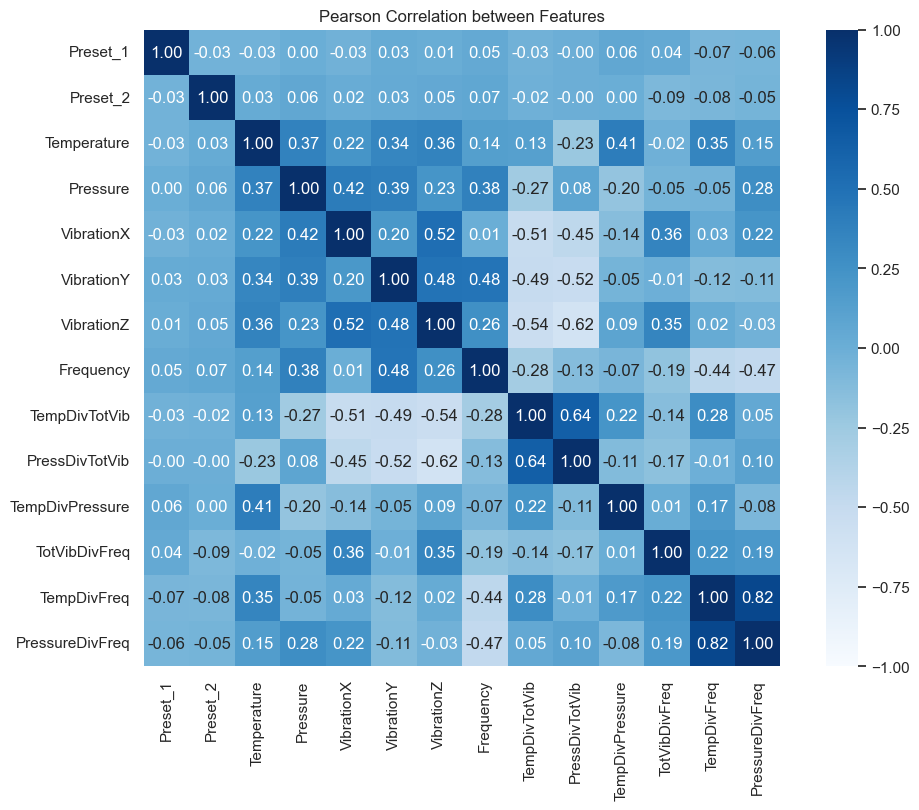

In [27]:
# Pearson Correlation
pearson_corr = df_train_lr[PRESET_COLS + LR_NUM_FEATURE_COLS] \
                    .corr(method='pearson')

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(pearson_corr,
            annot=True,
            fmt=".2f",
            vmax=1, vmin=-1, square=True, cmap='Blues')
plt.title('Pearson Correlation between Features')

Text(0.5, 1.0, 'Spearman Correlation between Features')

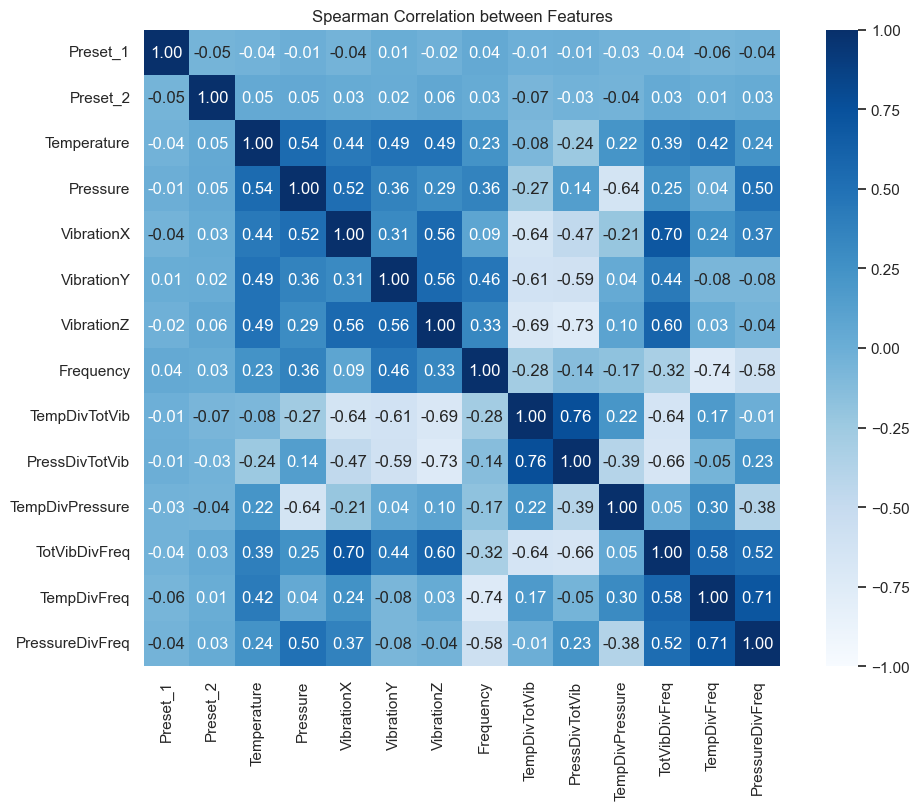

In [28]:
# Pearson Correlation
spearman_corr = df_train_lr[PRESET_COLS + LR_NUM_FEATURE_COLS] \
                    .corr(method='spearman')

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(spearman_corr,
            annot=True,
            fmt=".2f",
            vmax=1, vmin=-1, square=True, cmap='Blues')
plt.title('Spearman Correlation between Features')

The features highly correlated one each other are `TempDivFreq` and `PressureDivFreq`. I'll choose one of them after check the Kolmogorov-Smirnov test of all features - The idea is select that have the higher separation between failures and non-failure samples.

In [29]:
# KS Teste
for c in PRESET_COLS + LR_NUM_FEATURE_COLS:
    dist_0 = df_train_lr.loc[df_train_lr[TARGET_COL]==0, c]
    dist_1 = df_train_lr.loc[df_train_lr[TARGET_COL]==1, c]

    ks_stat, p_val = ks_2samp(dist_0, dist_1)

    spaces_1 = " " * (15 - len(c))
    spaces_2 = " " * (4 - len(str(int(ks_stat))))

    print(c + spaces_1 + '|    KS Stat.: {:.2f}'.format(ks_stat) + \
          spaces_2 + '| p-value: {:.4f}'.format(p_val))

Preset_1       |    KS Stat.: 0.14   | p-value: 0.3497
Preset_2       |    KS Stat.: 0.11   | p-value: 0.6558
Temperature    |    KS Stat.: 0.57   | p-value: 0.0000
Pressure       |    KS Stat.: 0.54   | p-value: 0.0000
VibrationX     |    KS Stat.: 0.52   | p-value: 0.0000
VibrationY     |    KS Stat.: 0.64   | p-value: 0.0000
VibrationZ     |    KS Stat.: 0.61   | p-value: 0.0000
Frequency      |    KS Stat.: 0.56   | p-value: 0.0000
TempDivTotVib  |    KS Stat.: 0.57   | p-value: 0.0000
PressDivTotVib |    KS Stat.: 0.47   | p-value: 0.0000
TempDivPressure|    KS Stat.: 0.18   | p-value: 0.1017
TotVibDivFreq  |    KS Stat.: 0.43   | p-value: 0.0000
TempDivFreq    |    KS Stat.: 0.22   | p-value: 0.0256
PressureDivFreq|    KS Stat.: 0.19   | p-value: 0.0945


**Conclusion:** In order to avoid multicolinearity and choose the best predictor, we'll remove just `PressureDivFreq` and keep `TempDivFreq`.

In [30]:
df_train_lr.drop('PressureDivFreq', axis=1, inplace=True)
df_test_lr.drop('PressureDivFreq', axis=1, inplace=True)

LR_NUM_FEATURE_COLS.remove('PressureDivFreq')
LR_FINAL_FEATURES = PRESET_COLS + LR_NUM_FEATURE_COLS

#### Model Development

Firstly we;ll develop a simplified version of each model, deal with model parameters just taking care to avoid some overfitting. After choose between Logistic Regression or Random Forest, we'll perform the model hyperparameter tuning step.

**Logistic Regression Classifier**

Using `LogisticRegressionCV` from Scikit-Learning


In [31]:
lr = LogisticRegressionCV(Cs=np.linspace(1e-4, 1e4, num=10),
                          l1_ratios=np.linspace(0, 1, 10),
                          cv=5,
                          solver='saga',
                          penalty='elasticnet',
                          scoring='average_precision',
                          class_weight='balanced')

lr.fit(X=df_train_lr[LR_FINAL_FEATURES], y=df_train_lr[TARGET_COL])

# Keep the best params
rl_best_params = {
    'C': lr.C_[0],
    'l1_ratio': lr.l1_ratio_[0],
    'solver': 'saga',
    'penalty': 'elasticnet',
    'class_weight': 'balanced'
}

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

In [32]:
# Train Predictions:
train_predictions = lr.predict(df_train_lr[LR_FINAL_FEATURES])
train_scores = lr.predict_proba(df_train_lr[LR_FINAL_FEATURES])
train_scores = [x[1] for x in train_scores]

lr_train_pred = pd.DataFrame({'y_true': df_train_lr[TARGET_COL],
                              'y_pred': train_predictions,
                              'score': train_scores})


# Test Predictions:
test_predictions = lr.predict(df_test_lr[LR_FINAL_FEATURES])
test_scores = lr.predict_proba(df_test_lr[LR_FINAL_FEATURES])
test_scores = [x[1] for x in test_scores]

lr_test_pred = pd.DataFrame({'y_true': df_test_lr[TARGET_COL],
                              'y_pred': test_predictions,
                              'score': test_scores})


# Avg Precision Metric:
train_avg_precision = average_precision_score(df_train_lr[TARGET_COL], train_scores)
test_avg_precision = average_precision_score(df_test_lr[TARGET_COL], test_scores)

# ROCAUC Precision Metric:
train_roc_auc = roc_auc_score(df_train_lr[TARGET_COL], train_scores)
test_roc_auc = roc_auc_score(df_test_lr[TARGET_COL], test_scores)

print('----------------------------------')
print('Average Precision Metric:')
print('Train: {:.4f}'.format(train_avg_precision))
print('Test:  {:.4f}'.format(test_avg_precision))

print('----------------------------------')
print('ROC-AUC Metric:')
print('Train: {:.4f}'.format(train_roc_auc))
print('Test:  {:.4f}'.format(test_roc_auc))

----------------------------------
Average Precision Metric:
Train: 0.7490
Test:  0.7400
----------------------------------
ROC-AUC Metric:
Train: 0.9728
Test:  0.9768


**Logistic Regression Pipeline**

With the objective of avoiding some leakage during the data transformations required by linear models, we'll put all steps that have a `fit` method together inside a scikit-learning pipeline. 

In [33]:
from sklearn.pipeline import Pipeline

# Define a Logistic Regression with best params
lr = LogisticRegression(**rl_best_params)


lr_pipeline = Pipeline(
    steps=[('robust_scaler', robust_scaler), 
           ('scaler', scaler),
           ('logistic_regression', lr)]
)

# Redefine train and test sets
df_train_lr = pd.DataFrame(data=X_train, columns=FULL_FEATURE_COLS)
df_train_lr[TARGET_COL] = y_train

df_test_lr = pd.DataFrame(data=X_test, columns=FULL_FEATURE_COLS)
df_test_lr[TARGET_COL] = y_test

# Recreating the relationship features
df_train_lr, _ = create_relationships(df_train_lr)
df_test_lr, _ = create_relationships(df_test_lr)

# Train all pipeline
lr_pipeline.fit(df_train_lr[LR_FINAL_FEATURES], df_train_lr[TARGET_COL])

Pipeline(steps=[('robust_scaler', RobustScaler()), ('scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    l1_ratio=0.0, penalty='elasticnet',
                                    solver='saga'))])

**3.2 - Random Forest Classifier**

Firstly we'll use the default model parameter, just setting the parameters `class_weight=True` to handle the low proportion of failures on target variable, `max_depht=3` and `ccp_alpha=0.01` in order to use shallow trees and pruning the trees to avoid overfitting.


In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', max_depth=3, ccp_alpha=0.01)

rf.fit(df_train_rf[FULL_FEATURE_COLS], y=df_train_rf[TARGET_COL])

RandomForestClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=3)

In [35]:
# Train Predictions:
train_predictions = rf.predict(df_train_rf[FULL_FEATURE_COLS])
train_scores = rf.predict_proba(df_train_rf[FULL_FEATURE_COLS])
train_scores = [x[1] for x in train_scores]

lr_train_pred = pd.DataFrame({'y_true': df_train_rf[TARGET_COL],
                              'y_pred': train_predictions,
                              'score': train_scores})


# Test Predictions:
test_predictions = rf.predict(df_test_rf[FULL_FEATURE_COLS])
test_scores = rf.predict_proba(df_test_rf[FULL_FEATURE_COLS])
test_scores = [x[1] for x in test_scores]

lr_test_pred = pd.DataFrame({'y_true': df_test_rf[TARGET_COL],
                              'y_pred': test_predictions,
                              'score': test_scores})


# Avg Precision Metric:
train_avg_precision = average_precision_score(df_train_rf[TARGET_COL], train_scores)
test_avg_precision = average_precision_score(df_test_rf[TARGET_COL], test_scores)

# ROCAUC Precision Metric:
train_roc_auc = roc_auc_score(df_train_rf[TARGET_COL], train_scores)
test_roc_auc = roc_auc_score(df_test_rf[TARGET_COL], test_scores)

print('----------------------------------')
print('Average Precision Metric:')
print('Train: {:.4f}'.format(train_avg_precision))
print('Test:  {:.4f}'.format(test_avg_precision))

print('----------------------------------')
print('ROC-AUC Metric:')
print('Train: {:.4f}'.format(train_roc_auc))
print('Test:  {:.4f}'.format(test_roc_auc))

----------------------------------
Average Precision Metric:
Train: 0.8542
Test:  0.7680
----------------------------------
ROC-AUC Metric:
Train: 0.9885
Test:  0.9811


**3.3 - Comparing the Models**

**Metric Comparision with Bootstrap:** To perform a fair comparision inside a confidence interval, we'll evaluate the validation metric using the bootstrap methodology, implemented on the function bellow.

In [36]:
SklearnMetrics = Union[average_precision_score, roc_auc_score]
SklearnModels = Union[LogisticRegressionCV, RandomForestClassifier]

def bootstrap_metric(df: pd.DataFrame,
                     features:list,
                     target:str,
                     model:SklearnModels,
                     metric:SklearnMetrics,
                     n_boots:int = 20,
                     n_runs:int = 1000,
                     confidence_level=0.95):
    
    sample_size = 1/n_boots

    bs_metrics = {
        'run_number': [],
        'train_size': [],
        'test_size': [],
        'mean_train_target': [],
        'mean_test_target': [],
        'train_metric_score': [],
        'test_metric_score': [],
    }

    for i in tqdm(range(n_runs)):
        # Sample with replacement in each interaction
        X_train, X_test, y_train, y_test = train_test_split(
            df[features],
            df[target],
            test_size=sample_size,
            stratify=df[target],
            shuffle=True
        )

        # Train and evaluate metric
        model.fit(X_train, y_train)

        train_scores = [s[1] for s in model.predict_proba(X_train)]
        test_scores = [s[1] for s in model.predict_proba(X_test)]

        bs_metrics['run_number'].append(i)
        bs_metrics['train_size'].append(X_train.shape[0])
        bs_metrics['test_size'].append(X_test.shape[0])
        bs_metrics['mean_train_target'].append(np.mean(y_train))
        bs_metrics['mean_test_target'].append(np.mean(y_test))
        bs_metrics['train_metric_score'].append(metric(y_train, train_scores))
        bs_metrics['test_metric_score'].append(metric(y_test, test_scores))

    # Evaluate confidence interval
    lower_limit, upper_limit = t.interval(
        confidence=.95,
        df=len(bs_metrics['run_number']),
        loc=np.mean(bs_metrics['test_metric_score']),
        scale=sem(bs_metrics['test_metric_score'])
    )

    # Return interval metric limits and dict with all runs
    return lower_limit, upper_limit, bs_metrics


In [37]:
%%time
lr_lower_limit, lr_upper_limit, runs = bootstrap_metric(
    pd.concat([df_train_lr, df_test_lr]), 
    LR_FINAL_FEATURES,
    TARGET_COL,
    lr_pipeline,
    average_precision_score,
    n_boots=10,
    n_runs=1000
)

print("----- Logistic Regression: BS Metric Interval -----")
print("Limits: ", (lr_lower_limit, lr_upper_limit))
print("/nMetrics")
print("Train AvgPrecision Score: {:.4f}".format(np.mean(runs['train_metric_score'])))
print("Test  AvgPrecision Score: {:.4f}".format(np.mean(runs['test_metric_score'])))


  0%|          | 4/1000 [00:00<00:28, 35.43it/s]

100%|██████████| 1000/1000 [00:20<00:00, 47.94it/s]

----- Logistic Regression: BS Metric Interval -----
Limits:  (0.748679344255171, 0.7642794998799555)
/nMetrics
Train AvgPrecision Score: 0.7486
Test  AvgPrecision Score: 0.7565
CPU times: user 48.7 s, sys: 18.4 s, total: 1min 7s
Wall time: 20.9 s


In [38]:
%%time
rf = RandomForestClassifier(class_weight='balanced', max_depth=5, ccp_alpha=0.01)

rf_lower_limit, rf_upper_limit, runs = bootstrap_metric(
    pd.concat([df_train_lr, df_test_lr]),
    FULL_FEATURE_COLS,
    TARGET_COL,
    rf,
    average_precision_score,
    n_boots=10,
    n_runs=1000
)


print("----- Random Forest: BS Metric Interval -----")
print("Limits: ", (rf_lower_limit, rf_upper_limit))
print("/nMetrics")
print("Train AvgPrecision Score: {:.4f}".format(np.mean(runs['train_metric_score'])))
print("Test  AvgPrecision Score: {:.4f}".format(np.mean(runs['test_metric_score'])))

100%|██████████| 1000/1000 [03:34<00:00,  4.67it/s]

----- Random Forest: BS Metric Interval -----
Limits:  (0.7684779243041997, 0.7848617405011571)
/nMetrics
Train AvgPrecision Score: 0.8748
Test  AvgPrecision Score: 0.7767
CPU times: user 3min 17s, sys: 4.99 s, total: 3min 22s
Wall time: 3min 34s


**Conclusion:**
We see some advantages in using a non-linear model (Random Forest Classifier):
- Didn't require any assumptions about data distribution from predictors
- Requires less data treatment 
- The performance on validation set proved to be superior inside a confidence interval given by Bootstrap Methodology





**Parameter tunning**

Now we'll perform a fine-tunning of parameters from Logistic Regression Model

In [39]:
%%time
param_space = {
    'n_estimators': [int(n) for n in np.linspace(10, 1000, 10)],
    'n_estimators': np.random.choice(np.random.randint(10, 1000, size=10000), size=100, replace=False),
    'max_depth': [3, 5, 7, 10, 15, 20, 30, 50, None],
    'min_samples_split':[2, 3, 5, 7, 0.1, 0.3, 0.5, 0.7],
    'min_samples_leaf':[1, 2, 3, 5, 7, 0.1, 0.3, 0.5, 0.7],
    'ccp_alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    # Fixed Params
    'class_weight': ['balanced']
}

rand_search_cv = RandomizedSearchCV(rf,
                                    param_distributions=param_space,
                                    scoring='average_precision',
                                    n_jobs=-1)

rand_search_cv.fit(X=df_train_rf[FULL_FEATURE_COLS], y=df_train_rf[TARGET_COL])

# Best params
rand_search_cv.best_estimator_

CPU times: user 1.53 s, sys: 134 ms, total: 1.67 s
Wall time: 14.8 s


RandomForestClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=992)

**Model Performance** 

Checking the model performance using the follow methods

- Metrics:
    * Average Precision
    * ROC-AUC Score
    * Precision
    * Recall
    * Accuraccy

- Curves:
    * ROC Curve
    * CAP Curve
    * PR Curve


In [40]:
class validation_plots(ABC):

    @abstractmethod
    def _plot_roc_curve(y_true, y_scores, ax:plt.axes):
        
        fpr, tpr, threshold = roc_curve(y_true, y_scores)
        auroc = auc(fpr,tpr)

        label = 'AUC:' + ' {0:.2f}'.format(auroc)
        ax.plot([0,1], [0,1], 'r--')
        ax.plot(fpr, tpr, c='green', label=label)
        ax.set_title('Receiver Operating Characteristic')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()

        return ax
    

    @abstractmethod
    def _plot_cap_curve(y_true, y_scores, ax:plt.axes):
            
        tot_obs = len(y_true)   # Total observations
        y_1 = sum(y_true)       # quantity of observations with y==1
        y_0 = tot_obs - y_1     # quantity of observations with y==0

        # Random Model
        ax.plot([0, tot_obs],
                 [0, y_1],
                 c='r',
                 linestyle='--', 
                 label='Random Model')
        
        # Perfect Model
                # Random Model
        ax.plot([0, y_1, tot_obs],
                 [0, y_1, y_1],
                 c='gray',
                 label='Perfect Model')
        
        # Current Model
        y_sorted = [y for _, y in sorted(zip(y_scores, y_true), reverse=True)]

        # Note: x_values and y_values refering to plot axis 
        y_values = np.append([0], np.cumsum(y_sorted))
        x_values = np.arange(0, tot_obs + 1)

        # Cap curve
        ax.plot(x_values, y_values, c='b', label='Current Model')
        ax.set_title('Cumulative Accuracy Profile')
        ax.set_xlabel('Total observations')
        ax.set_ylabel('Class 1 observations')
        ax.legend(loc='lower right')
        # plt.show()

        return ax


    @abstractmethod
    def _plot_pr_curve(y_true, y_scores, ax:plt.axes):
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        
        avg_precision = average_precision_score(y_true, y_scores)
        label = 'Avg Precision Score:' + ' {0:.2f}'.format(avg_precision)

        # Dummy classification (mean of y)
        no_skill = sum(y_true) / len(y_true)
        
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--',
                label='Dummy Classifier')

        # plot the model precision-recall curve
        ax.plot(recall, precision, label=label)
        ax.set_title('Precision-Recall Curve')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        # plt.show()
        
        return ax
 
    @abstractmethod
    def get_validation_plots(y_true, y_scores):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        ax1 = validation_plots._plot_roc_curve(y_true, y_scores, ax1)
        ax2 = validation_plots._plot_cap_curve(y_true, y_scores, ax2)
        ax3 = validation_plots._plot_pr_curve(y_true, y_scores, ax3)

        fig.suptitle('Validation Curves')
        return fig
    

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


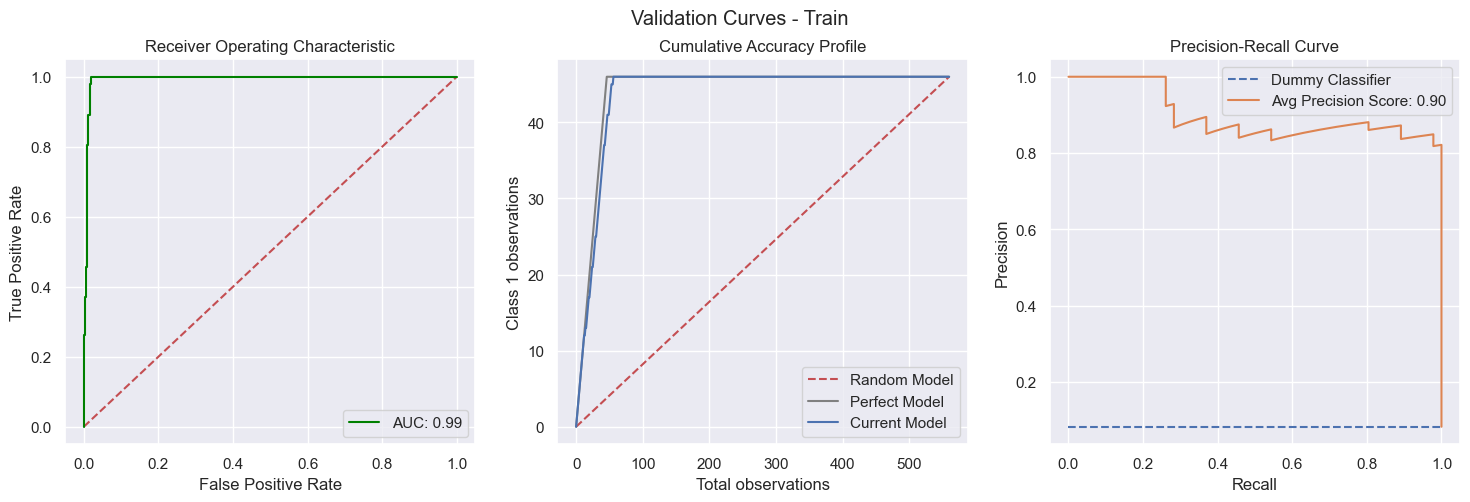

In [41]:
rf_model = rand_search_cv.best_estimator_.fit(df_train_rf[FULL_FEATURE_COLS],
                                              df_train_rf[TARGET_COL])

rf_train_scores = rf_model.predict_proba(df_train_rf[FULL_FEATURE_COLS])
rf_train_scores = rf_train_scores[:, 1]

fig = validation_plots.get_validation_plots(df_train_rf[TARGET_COL].values, rf_train_scores)
fig.suptitle('Validation Curves - Train')
fig.show()

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


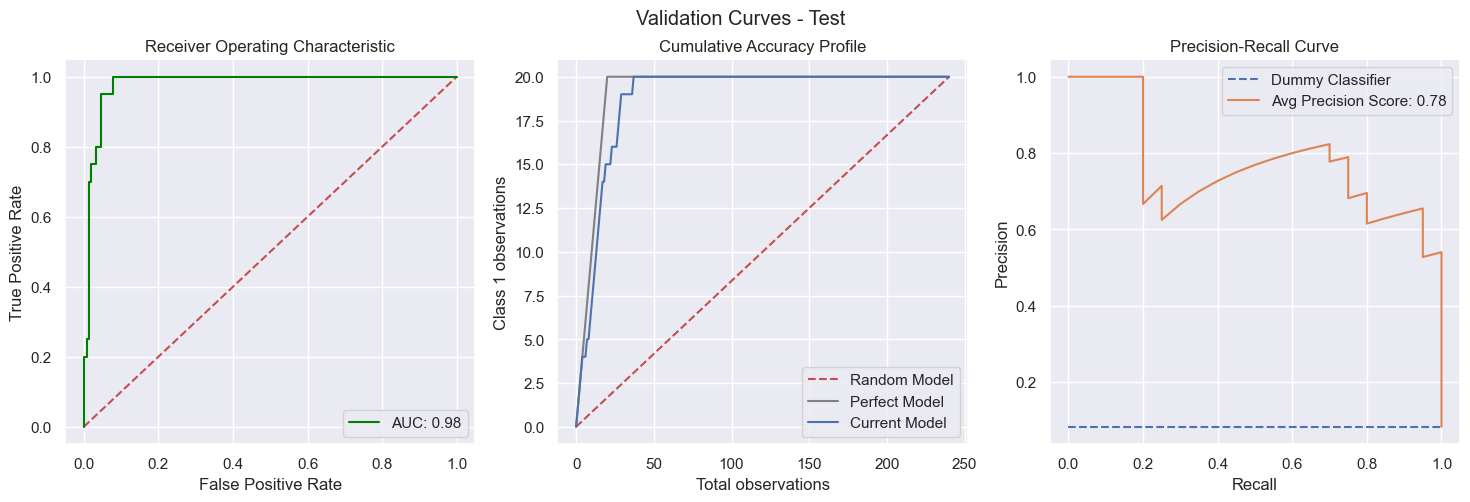

In [42]:
rf_test_scores = rf_model.predict_proba(df_test_rf[FULL_FEATURE_COLS])
rf_test_scores = rf_test_scores[:, 1]

fig = validation_plots.get_validation_plots(df_test_rf[TARGET_COL].values, rf_test_scores)
fig.suptitle('Validation Curves - Test')
fig.show()

**Model Explainability**

Using SHAP to explain how the predictors contribute, on average, with model classifications.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


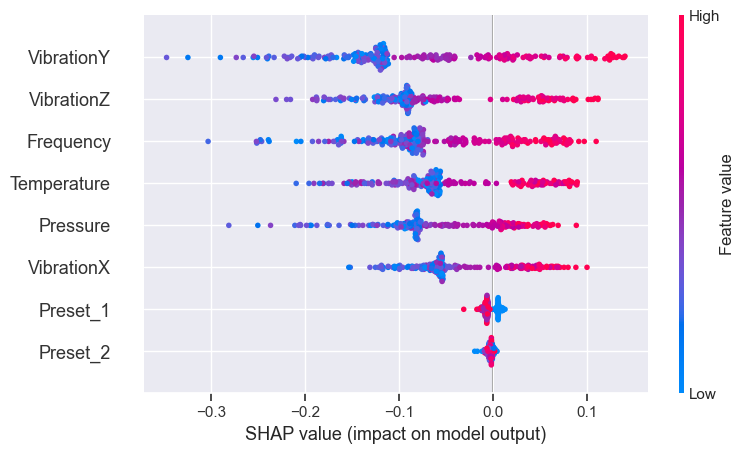

In [43]:
# Inicialize the explainer and calculate shap values
explainer = TreeExplainer(rf_model)
shap_values = np.array(explainer.shap_values(df_test_rf[FULL_FEATURE_COLS]))

# Create summary_plot
summary_plot(shap_values[1], df_test_rf[FULL_FEATURE_COLS])

**Conclusions:**
- High values for `VibrationY` and `VibrationZ` presents the major contribution to predict `Fail=1`
- `Preset1` and `Preset2` appears to not contribute at final decision. I think that occours because these configuration setups are the causes of the increasement or decreasement of parameters values (such as Vibrations, Temperature, Frenquency and Pressure) - e.g. a specific combination may causes high values for `VibrationY` and, consequently, this can be the cause of a failure. 

**Model Calibration** 

Random Forest can provide a score that can be used to ordering the observations by the probability of failures, but this score isn't a proper probability. In order to transform this score in a probability, we need perform a model calibration.

We'll test two techniques: isotonic calibration and logistic calibration. 

Calibration Curve

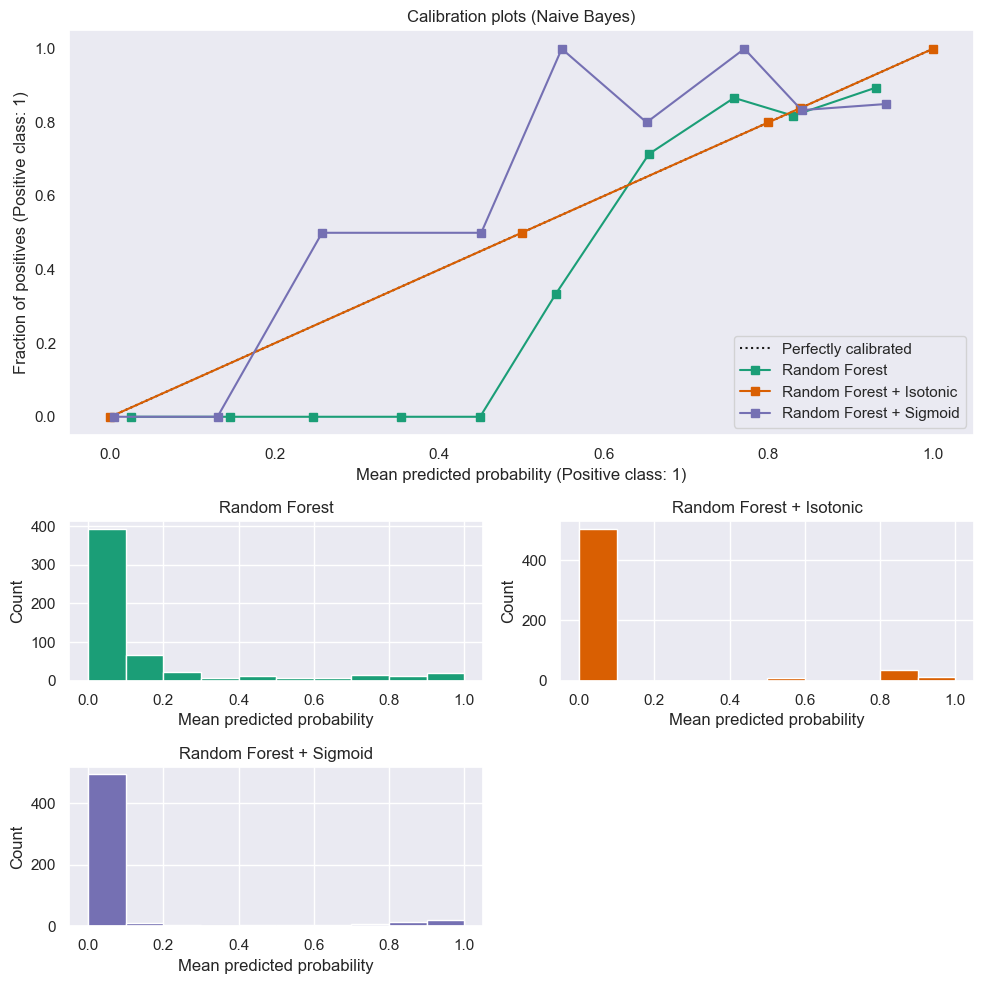

In [44]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")


rf_isotonic = CalibratedClassifierCV(rf_model, cv='prefit', method="isotonic")
rf_sigmoid = CalibratedClassifierCV(rf_model, cv='prefit', method="sigmoid")

clf_list = [
    (rf_model, "Random Forest"),
    (rf_isotonic, "Random Forest + Isotonic"),
    (rf_sigmoid, "Random Forest + Sigmoid"),
]

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(df_train_rf[FULL_FEATURE_COLS], df_train_rf[TARGET_COL])
    display = CalibrationDisplay.from_estimator(
        clf,
        df_train_rf[FULL_FEATURE_COLS],
        df_train_rf[TARGET_COL],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

**Conclusion:** the Isotonic Calibration proved to be the best technique for this model. 

### <a id='sec_4'>4. Final Considerations</a>

**Conclusions**

- With the provided dataset, we are able to build a predictive model to infer the probability of failure given sensors readings of specific parameters with good model fitting;
- The configurations setups are didn't have good predictive power, but this sets are the causes of increases for some parameters, such as related by vibrations, and these increasements are the causes of failures.


**Possible Improvements**

In addition to the tested models, a very rich technique for this kind of problem are the survival models, such as Randon Survival Forests (a tree-based survival model).

The survival model requires two targets: one representing the _time to event_ and another representing the occurence of the event. In the provided dataset, we can calculate the time to event by counting the quantity of cicles between failures. This kind of model can give to us, as well as the probability of failure, a inference of how much time until the failure, and this information can be very useful for the context of planning preventive maitenances.

The main advantage about this technique is the time inference taht represents time until a fail given the parameters values. These inferences allows planning preventive maitenances based on an amount of time until the equipment present a fail, deciding between taking immediate actions or schedule more precisely the non-immediate actions. 


**Considerations**

Because of the small amount of predictors, a complex model such as boosting models are not so useful in terms of bias-variance trade-off - in this case, using boosting methods will increase the variance in exchenge of small improvements in performance metrics but incriasing the possibility of overfitting. Because of that, I opted to not use this kind of model, instead I use a random forest classifier model that shows good performance.


[(back to Table of Contents)](#index)
